## 0. Data Exploration
Inspect the raw `.npz` file structure before loading the full dataset.

In [4]:
import numpy as np
import zipfile
import io
from pathlib import Path
import matplotlib.pyplot as plt

# ── Point this at ONE of your Town zip files ──────────────────────────
CHANNEL_ZIP = Path("/Volumes/multi_modal/sunny/Channel Data/V2I/Nt_1_16_Nr_1_16_fc_28GHz/Town03.zip")

print("=" * 70)
print("CHANNEL ZIP CONTENTS")
print("=" * 70)

with zipfile.ZipFile(CHANNEL_ZIP, "r") as z:
    all_files = z.namelist()
    npz_files = [f for f in all_files if f.endswith("_paths.npz")]
    yaml_files = [f for f in all_files if f.endswith(".yaml")]
    print(f"  .npz files  : {len(npz_files)}")
    print(f"  .yaml files : {len(yaml_files)}")
    print(f"  First 5 npz : {npz_files[:5]}")

    # Load the first .npz for inspection
    raw = z.read(npz_files[0])

npz = np.load(io.BytesIO(raw))
print("\n" + "=" * 70)
print(f"NPZ FILE: {npz_files[0]}")
print("=" * 70)
print(f"  Keys: {npz.files}")
for k in npz.files:
    arr = npz[k]
    print(f"  [{k}]  shape={arr.shape}  dtype={arr.dtype}  "
          f"min={np.abs(arr).min():.4g}  max={np.abs(arr).max():.4g}")


CHANNEL ZIP CONTENTS
  .npz files  : 15700
  .yaml files : 15700
  First 5 npz : ['Town03/Town03_Tjunction/cav_1/004276_paths.npz', 'Town03/Town03_Tjunction/cav_1/004283_paths.npz', 'Town03/Town03_Tjunction/cav_1/004284_paths.npz', 'Town03/Town03_Tjunction/cav_1/004288_paths.npz', 'Town03/Town03_Tjunction/cav_1/004291_paths.npz']

NPZ FILE: Town03/Town03_Tjunction/cav_1/004276_paths.npz
  Keys: ['a', 'tau', 'theta_t', 'phi_t', 'theta_r', 'phi_r', 'glob_phi_t', 'glob_phi_r', 'glob_theta_t', 'glob_theta_r']
  [a]  shape=(1, 1, 16, 1, 16, 3, 1)  dtype=complex64  min=1.932e-06  max=3.076e-05
  [tau]  shape=(1, 1, 1, 3)  dtype=float32  min=0  max=8.499e-07
  [theta_t]  shape=(1, 1, 1, 3)  dtype=float32  min=1.591  max=1.726
  [phi_t]  shape=(1, 1, 1, 3)  dtype=float32  min=1.215  max=2.458
  [theta_r]  shape=(1, 1, 1, 3)  dtype=float32  min=1.192  max=1.792
  [phi_r]  shape=(1, 1, 1, 3)  dtype=float32  min=0.4003  max=3.115
  [glob_phi_t]  shape=(1, 1, 1, 3)  dtype=float32  min=0.6834  max=

In [5]:
# ── Inspect channel tensor 'a' in detail ─────────────────────────────
a = npz["a"]
print("Raw 'a' shape:", a.shape)

# Squeeze singleton dims → (Nr, Nt, n_paths)
a_sq = np.squeeze(a)
if a_sq.ndim == 2:
    a_sq = a_sq[:, :, np.newaxis]
nr, nt, n_paths = a_sq.shape
print(f"Squeezed: Nr={nr}, Nt={nt}, n_paths={n_paths}")

# Path-level power (sum over antennas)
path_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 1))  # (n_paths,)
total_power = path_power.sum()
print(f"\nPath powers : {path_power.round(6)}")
print(f"Total power : {total_power:.6g}")
print(f"Dominant path index : {np.argmax(path_power)}")
print(f"Dominant path ratio : {path_power.max() / (total_power + 1e-12):.3f}")

# Compute beam index (Tx antenna with highest received power)
tx_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 2))   # (Nt,)
beam_index = int(np.argmax(tx_power))
print(f"\nTx antenna powers (beam codebook): {tx_power.round(4)}")
print(f"Beam index (argmax Tx power)      : {beam_index}")


Raw 'a' shape: (1, 1, 16, 1, 16, 3, 1)
Squeezed: Nr=16, Nt=16, n_paths=3

Path powers : [0. 0. 0.]
Total power : 3.04838e-07
Dominant path index : 0
Dominant path ratio : 0.794

Tx antenna powers (beam codebook): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Beam index (argmax Tx power)      : 0


Beam distribution over 200 frames:
  Beam  0 |   88 | ██████████████████████████████
  Beam  1 |   32 | ██████████
  Beam  2 |   16 | █████
  Beam  3 |   13 | ████
  Beam  4 |    6 | ██
  Beam  5 |    5 | █
  Beam  6 |    6 | ██
  Beam  7 |    8 | ██
  Beam  8 |    6 | ██
  Beam  9 |    4 | █
  Beam 10 |    2 | 
  Beam 11 |    6 | ██
  Beam 12 |    2 | 
  Beam 13 |    2 | 
  Beam 14 |    2 | 
  Beam 15 |    2 | 


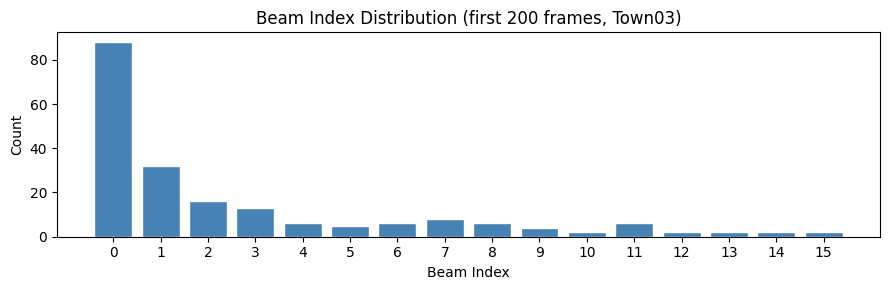

In [6]:
# ── Sample-level label distribution across N frames ──────────────────
N_SAMPLE = 200   # how many .npz files to scan for quick stats

beam_list = []
with zipfile.ZipFile(CHANNEL_ZIP, "r") as z:
    npz_files_scan = [f for f in z.namelist() if f.endswith("_paths.npz")][:N_SAMPLE]
    for fname in npz_files_scan:
        raw = z.read(fname)
        npz_s = np.load(io.BytesIO(raw))
        a_s = np.squeeze(npz_s["a"])
        if a_s.ndim == 2:
            a_s = a_s[:, :, np.newaxis]
        tx_p = np.sum(np.abs(a_s) ** 2, axis=(0, 2))
        beam_list.append(int(np.argmax(tx_p)))

beam_arr = np.array(beam_list)
counts = np.bincount(beam_arr, minlength=16)
print(f"Beam distribution over {len(beam_arr)} frames:")
for i, c in enumerate(counts):
    bar = "█" * int(c / max(counts) * 30)
    print(f"  Beam {i:2d} | {c:4d} | {bar}")

fig, ax = plt.subplots(figsize=(9, 3))
ax.bar(range(16), counts, color="steelblue", edgecolor="white")
ax.set_xlabel("Beam Index")
ax.set_ylabel("Count")
ax.set_title(f"Beam Index Distribution (first {len(beam_arr)} frames, Town03)")
ax.set_xticks(range(16))
plt.tight_layout()
plt.show()


## 1. Imports & Reproducibility

In [7]:
import numpy as np
import random
import os
import re
import io
import zipfile
import pickle
import hashlib
import time
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path, PurePosixPath
from typing import Dict, List, Optional, Sequence, Tuple, Union

import flwr as fl
import ray
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# ── Reproducibility ───────────────────────────────────────────────────
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = str(seed)
tf.keras.backend.clear_session()

results_dir = "experiment_results"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print("Random seeds set. TF version:", tf.__version__)


Random seeds set. TF version: 2.19.1


## 2. Configuration

In [8]:
CFG = {
    # Training
    "local_epochs"   : 3,
    "lr"             : 1e-3,
    "test_size"      : 0.2,

    # Beam focal loss
    "focal_gamma"    : 2.0,   # 0 = standard cross-entropy
    "label_smoothing": 0.05,
    "grad_clip_norm" : 5.0,

    # Federated
    "client_frac"    : 1.0,

    # Dataset
    "outage_threshold_db": {"outage_lt": 0.0, "degraded_lt": 10.0},
    "noise_power_ref"    : 1e-11,
}


## 3. Dataset

In [9]:
def _parse_total_antennas(config_name: str, side: str) -> int:
    m = re.search(rf"{side}_(\d+)_(\d+)", config_name)
    if not m:
        raise ValueError(f"Could not parse {side} from: {config_name}")
    return int(m.group(1)) * int(m.group(2))


def _safe_isfinite(x: np.ndarray) -> bool:
    if np.iscomplexobj(x):
        return np.isfinite(x.real).all() and np.isfinite(x.imag).all()
    return np.isfinite(x).all()


@dataclass(frozen=True)
class ChannelSampleRef:
    zip_path: Path
    inner_npz: str


In [10]:
class ChannelDataset:
    """
    Channel-only dataset over *_paths.npz files inside TownXX.zip.
    Each sample = ONE frame_id = ONE *_paths.npz.
    Only 'beam_index' label is produced (beam-only mode).
    """

    def __init__(
        self,
        root: Union[str, Path],
        config_name: str,
        towns: Optional[Sequence[str]] = None,
        scenario_contains: Optional[str] = None,
        cav_contains: Optional[str] = None,
        stride: int = 1,
        return_real_imag: bool = True,
        expected_num_paths: Optional[int] = None,
        assert_no_nans: bool = True,
        assert_shapes: bool = True,
        top_k_paths: Optional[int] = None,
        pad_if_short: bool = True,
    ):
        self.root = Path(root)
        self.config_name = config_name
        self.config_dir = self.root / "sunny" / "Channel Data" / "V2I" / config_name

        if not self.config_dir.exists():
            raise FileNotFoundError(f"Config dir not found: {self.config_dir}")

        self.nt = _parse_total_antennas(config_name, "Nt")
        self.nr = _parse_total_antennas(config_name, "Nr")

        self.towns = list(towns) if towns else None
        self.scenario_contains = scenario_contains
        self.cav_contains = cav_contains
        self.stride = max(1, int(stride))
        self.return_real_imag = return_real_imag
        self.expected_num_paths = expected_num_paths
        self.assert_no_nans = assert_no_nans
        self.assert_shapes = assert_shapes
        self.top_k_paths = top_k_paths
        self.pad_if_short = pad_if_short

        self.index: List[ChannelSampleRef] = self._build_index()
        if self.stride > 1:
            self.index = self.index[:: self.stride]

        self._expected_csi_shape: Optional[Tuple[int, ...]] = None

    # ── Index building ─────────────────────────────────────────────────
    def _build_index(self) -> List[ChannelSampleRef]:
        if self.towns is None:
            zips = sorted(self.config_dir.glob("Town*.zip"))
        else:
            zips = [self.config_dir / f"{t}.zip" for t in self.towns]

        refs: List[ChannelSampleRef] = []
        for zp in zips:
            if not zp.exists():
                continue
            with zipfile.ZipFile(zp, "r") as z:
                for name in z.namelist():
                    if not name.endswith("_paths.npz"):
                        continue
                    p = PurePosixPath(name)
                    if self.scenario_contains and self.scenario_contains.lower() not in str(p).lower():
                        continue
                    if self.cav_contains and self.cav_contains.lower() not in str(p).lower():
                        continue
                    refs.append(ChannelSampleRef(zip_path=zp, inner_npz=name))

        def sort_key(ref: ChannelSampleRef):
            p = PurePosixPath(ref.inner_npz)
            m = re.match(r"(\d+)_paths$", p.stem)
            return (str(ref.zip_path), str(p.parent), int(m.group(1)) if m else -1)

        refs.sort(key=sort_key)
        if not refs:
            raise ValueError(f"No *_paths.npz found under {self.config_dir}")
        return refs

    # ── Metadata ───────────────────────────────────────────────────────
    def _parse_metadata(self, inner_path: str) -> Dict[str, str]:
        p = PurePosixPath(inner_path)
        m = re.match(r"(\d+)_paths\.npz$", p.name)
        frame_id = int(m.group(1)) if m else -1
        cav_id = p.parent.name if "cav" in p.parent.name.lower() else "unknown"
        location = p.parent.parent.name or "unknown"
        return {"location": location, "cav_id": cav_id, "frame_id": frame_id}

    def get_sample_metadata(self, idx: int) -> Dict[str, str]:
        ref = self.index[idx]
        meta = self._parse_metadata(ref.inner_npz)
        meta["town"] = ref.zip_path.stem
        meta["zip_path"] = str(ref.zip_path)
        meta["inner_path"] = ref.inner_npz
        return meta

    def build_metadata_index(self) -> pd.DataFrame:
        rows = []
        for idx in range(len(self)):
            meta = self.get_sample_metadata(idx)
            meta["sample_idx"] = idx
            rows.append(meta)
        return pd.DataFrame(rows)

    # ── Core loading ───────────────────────────────────────────────────
    def __len__(self) -> int:
        return len(self.index)

    def _load_npz(self, ref: ChannelSampleRef) -> Dict[str, np.ndarray]:
        with zipfile.ZipFile(ref.zip_path, "r") as z:
            raw = z.read(ref.inner_npz)
        npz = np.load(io.BytesIO(raw))
        return {k: npz[k] for k in npz.files}

    def _extract_csi(self, arrays: Dict[str, np.ndarray]) -> np.ndarray:
        a = arrays["a"]  # complex, shape (1,1,Nr,1,Nt,n_paths,1) typically
        if self.assert_no_nans:
            assert _safe_isfinite(a), "Non-finite in 'a'"

        a_sq = np.squeeze(a)
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]
        if a_sq.ndim != 3:
            raise ValueError(f"Unexpected squeezed 'a' shape: {a_sq.shape}")

        nr, nt, n_paths = a_sq.shape

        # ── Channel-index calculation: top-K paths by power ───────────
        if self.top_k_paths is not None:
            K = self.top_k_paths
            path_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 1))  # (n_paths,)
            topk_idx = np.argsort(path_power)[::-1][:K]           # descending
            a_sq = a_sq[:, :, topk_idx]                           # (Nr, Nt, K)
            if a_sq.shape[2] < K and self.pad_if_short:
                pad = K - a_sq.shape[2]
                a_sq = np.pad(a_sq, ((0, 0), (0, 0), (0, pad)), mode="constant")

        if self.return_real_imag:
            csi = np.stack([a_sq.real, a_sq.imag], axis=-1).astype(np.float32)
        else:
            csi = a_sq

        if self.assert_no_nans:
            assert _safe_isfinite(csi), "Non-finite in csi tensor"
        return csi

    def _beam_index(self, a_sq: np.ndarray) -> int:
        """Beam = Tx antenna index with maximum received power."""
        tx_power = np.sum(np.abs(a_sq) ** 2, axis=(0, 2))  # (Nt,)
        return int(np.argmax(tx_power))

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, Dict[str, np.ndarray]]:
        ref = self.index[idx]
        arrays = self._load_npz(ref)

        a_sq = np.squeeze(arrays["a"])
        if a_sq.ndim == 2:
            a_sq = a_sq[:, :, np.newaxis]

        csi_tensor = self._extract_csi(arrays)

        if self.assert_shapes:
            if self._expected_csi_shape is None:
                self._expected_csi_shape = tuple(csi_tensor.shape)
            else:
                assert tuple(csi_tensor.shape) == self._expected_csi_shape, (
                    f"CSI shape mismatch: {self._expected_csi_shape} vs {csi_tensor.shape}"
                )

        labels = {"beam_index": np.array(self._beam_index(a_sq), dtype=np.int64)}
        return csi_tensor, labels


## 4. Trajectory-Based Client Builder

In [11]:
class DatasetSplitter:
    """Trajectory-aware train/test splitting (1 client = 1 CAV trajectory)."""

    def __init__(self, dataset: ChannelDataset):
        self.dataset = dataset
        self.metadata_df = dataset.build_metadata_index()
        print(f"Metadata index built: {len(self.metadata_df)} samples")

    def get_trajectory_groups(self) -> Dict[str, List[int]]:
        trajectories = {}
        for (town, location, cav_id), group in self.metadata_df.groupby(
            ["town", "location", "cav_id"]
        ):
            traj_id = f"{town}_{location}_{cav_id}"
            trajectories[traj_id] = group.sort_values("frame_id")["sample_idx"].tolist()
        return trajectories

    def split_trajectory_temporal(
        self, indices: List[int], train_ratio: float = 0.7
    ) -> Tuple[List[int], List[int]]:
        split = int(len(indices) * train_ratio)
        return indices[:split], indices[split:]


@dataclass
class ChannelClientData:
    train_indices: List[int]
    test_indices: List[int]
    client_id: int
    trajectory_id: str


def build_clients(
    dataset: ChannelDataset,
    train_ratio: float = 0.7,
    min_trajectory_length: int = 10,
) -> List[ChannelClientData]:
    splitter = DatasetSplitter(dataset)
    trajectories = splitter.get_trajectory_groups()
    print(f"Total trajectories: {len(trajectories)}")

    trajectories = {
        t: idx for t, idx in trajectories.items() if len(idx) >= min_trajectory_length
    }
    print(f"After length filter (>={min_trajectory_length}): {len(trajectories)}")

    clients = []
    for cid, traj_id in enumerate(sorted(trajectories)):
        train_idx, test_idx = splitter.split_trajectory_temporal(
            trajectories[traj_id], train_ratio
        )
        if not train_idx or not test_idx:
            continue
        clients.append(
            ChannelClientData(train_idx, test_idx, cid, traj_id)
        )
    print(f"Clients created: {len(clients)}")
    return clients


## 5. Load Dataset & Build Clients

In [12]:
ds = ChannelDataset(
    root="/Volumes/multi_modal",
    config_name="Nt_1_16_Nr_1_16_fc_28GHz",
    towns=["Town03", "Town05"],
    stride=10,
    top_k_paths=6,
    pad_if_short=True,
    expected_num_paths=None,
)
print(f"Dataset size: {len(ds)} samples")

x, y = ds[0]
print(f"CSI shape : {x.shape}")   # (Nr, Nt, K, 2)
print(f"Labels    : {y}")          # {'beam_index': ...}


Dataset size: 3280 samples
CSI shape : (16, 16, 6, 2)
Labels    : {'beam_index': array(0)}


In [13]:
clients = build_clients(ds, train_ratio=0.7, min_trajectory_length=10)


Metadata index built: 3280 samples
Total trajectories: 31
After length filter (>=10): 31
Clients created: 31


## 6. Compute Beam Class Weights

In [14]:
print("Collecting beam labels...")
all_beam = np.array([ds[i][1]["beam_index"] for i in range(len(ds))])
print(f"Collected {len(all_beam)} samples")

beam_counts = np.bincount(all_beam, minlength=16)
beam_weights = len(all_beam) / (16 * beam_counts + 1e-9)
beam_weights = beam_weights / beam_weights.sum() * 16

print("\nBeam class weights:")
for i, w in enumerate(beam_weights):
    print(f"  Beam {i:2d}: {w:.4f}")

np.save("beam_class_weights.npy", beam_weights)
print("\nSaved → beam_class_weights.npy")


Collected 3280 samples

Beam class weights:
  Beam  0: 0.0568
  Beam  1: 0.1684
  Beam  2: 0.3298
  Beam  3: 0.3888
  Beam  4: 0.4374
  Beam  5: 0.5589
  Beam  6: 0.9358
  Beam  7: 0.9581
  Beam  8: 1.2381
  Beam  9: 1.4371
  Beam 10: 1.3193
  Beam 11: 1.3641
  Beam 12: 1.4371
  Beam 13: 1.5185
  Beam 14: 1.6767
  Beam 15: 2.1751

Saved → beam_class_weights.npy


## 7. Model Architecture (Beam Only)

In [15]:
class ChannelEncoder(tf.keras.Model):
    """Convolutional path encoder with attention pooling."""

    def __init__(self, nr: int, nt: int, top_k_paths: int,
                 beam_codebook_size: int, emb_dim: int = 128, dropout: float = 0.0):
        super().__init__()
        self.nr = nr
        self.nt = nt
        self.k = top_k_paths
        self.emb_dim = emb_dim

        self.conv1 = keras.layers.Conv2D(32, 3, padding="same", activation="relu")
        self.conv2 = keras.layers.Conv2D(64, 3, padding="same", activation="relu")
        self.conv3 = keras.layers.Conv2D(64, 1, padding="same", activation="relu")
        self.gap = keras.layers.GlobalAveragePooling2D()
        self.att_dense = keras.layers.Dense(1)
        self.proj = keras.Sequential([
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(emb_dim),
        ])

    def call(self, x, training=False):
        # x: (B, Nr, Nt, P, 2) or (Nr, Nt, P, 2)
        if tf.rank(x) == 4:
            x = tf.expand_dims(x, 0)

        # Select top-K paths by power
        power = tf.reduce_sum(tf.square(x), axis=[0, 1, 2, 4])
        k = tf.minimum(self.k, tf.shape(power)[0])
        idx = tf.math.top_k(power, k=k, sorted=True).indices
        x = tf.gather(x, idx, axis=3)          # (B, Nr, Nt, K, 2)

        # Per-path CNN
        x = tf.transpose(x, [0, 3, 1, 2, 4])  # (B, K, Nr, Nt, 2)
        b, k2, nr, nt, _ = (tf.shape(x)[i] for i in range(5))
        x = tf.reshape(x, [-1, nr, nt, 2])     # (B*K, Nr, Nt, 2)
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.gap(h)                         # (B*K, 64)
        h = tf.reshape(h, [b, k2, -1])          # (B, K, 64)

        # Attention pooling
        att = tf.nn.softmax(self.att_dense(h), axis=1)
        h = tf.reduce_sum(att * h, axis=1)      # (B, 64)
        return self.proj(h, training=training)  # (B, emb_dim)


In [16]:
class BeamModel(keras.Model):
    """Beam-prediction-only federated model."""

    def __init__(self, nr: int, nt: int, top_k_paths: int,
                 beam_codebook_size: int, dropout: float = 0.0):
        super().__init__()
        self.encoder = ChannelEncoder(nr, nt, top_k_paths, beam_codebook_size,
                                      emb_dim=128, dropout=dropout)
        self.shared1 = keras.layers.Dense(256, activation="relu")
        self.shared2 = keras.layers.Dense(128, activation="relu")
        self.beam_dense = keras.layers.Dense(64, activation="relu")
        self.beam_head = keras.layers.Dense(beam_codebook_size)  # logits

    def call(self, x, training=False):
        emb = self.encoder(x, training=training)
        h = self.shared1(emb)
        h = self.shared2(h)
        h = self.beam_dense(h)
        return self.beam_head(h)  # (B, beam_codebook_size)

    def build_model(self, nr, nt, k):
        dummy = tf.random.normal((1, nr, nt, k, 2))
        _ = self(dummy, training=False)
        self.built = True


## 8. Flower Client (Beam Only)

In [17]:
class BeamFlowerClient(fl.client.NumPyClient):
    """
    Federated client — beam prediction only.
    Uses focal loss with class weights and label smoothing.
    """

    def __init__(self, model, dataset, train_indices, test_indices, cfg, trajectory_id):
        self.model = model
        self.dataset = dataset
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.cfg = cfg
        self.trajectory_id = trajectory_id
        self.optimizer = keras.optimizers.Adam(cfg["lr"])
        self.beam_class_weights = tf.constant(
            np.load("beam_class_weights.npy"), dtype=tf.float32
        )
        self.focal_gamma = cfg.get("focal_gamma", 2.0)
        self.label_smoothing = cfg.get("label_smoothing", 0.05)
        self.grad_clip_norm = cfg.get("grad_clip_norm", 5.0)

    # ── Focal loss ─────────────────────────────────────────────────────
    def focal_loss(self, labels, logits):
        num_classes = tf.shape(logits)[-1]
        if self.label_smoothing > 0:
            oh = tf.one_hot(labels, depth=num_classes)
            oh = oh * (1 - self.label_smoothing) + self.label_smoothing / tf.cast(num_classes, tf.float32)
            ce = tf.nn.softmax_cross_entropy_with_logits(labels=oh, logits=logits)
        else:
            ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)

        probs = tf.nn.softmax(logits, axis=-1)
        p_t = tf.reduce_sum(probs * tf.one_hot(labels, num_classes), axis=-1)
        focal_w = tf.pow(1.0 - p_t, self.focal_gamma)
        sample_w = tf.gather(self.beam_class_weights, labels)
        return tf.reduce_mean(focal_w * sample_w * ce)

    # ── Data loading ───────────────────────────────────────────────────
    def _load(self, indices):
        X, y = [], []
        for i in indices:
            x, labels = self.dataset[i]
            X.append(x)
            y.append(labels["beam_index"])
        return np.stack(X).astype(np.float32), np.array(y, dtype=np.int32)

    def _ensure_built(self):
        if self.model.built:
            return
        idx = self.train_indices[0] if self.train_indices else 0
        x, _ = self.dataset[idx]
        self.model(tf.convert_to_tensor(x[np.newaxis], dtype=tf.float32), training=False)
        self.model.built = True

    # ── Flower interface ───────────────────────────────────────────────
    def get_parameters(self, config):
        self._ensure_built()
        return self.model.get_weights()

    def fit(self, parameters, config):
        self._ensure_built()
        self.model.set_weights(parameters)
        X_train, y_train = self._load(self.train_indices)

        for _ in range(self.cfg["local_epochs"]):
            with tf.GradientTape() as tape:
                logits = self.model(
                    tf.convert_to_tensor(X_train, tf.float32), training=True
                )
                loss = self.focal_loss(tf.convert_to_tensor(y_train, tf.int32), logits)

            grads = tape.gradient(loss, self.model.trainable_weights)
            safe_grads = [g if g is not None else tf.zeros_like(v)
                          for g, v in zip(grads, self.model.trainable_weights)]
            clipped, _ = tf.clip_by_global_norm(safe_grads, self.grad_clip_norm)
            self.optimizer.apply_gradients(zip(clipped, self.model.trainable_weights))

        return self.model.get_weights(), len(self.train_indices), {
            "loss": float(loss.numpy()),
            "trajectory_id": self.trajectory_id,
        }

    def evaluate(self, parameters, config):
        self._ensure_built()
        self.model.set_weights(parameters)
        X_test, y_test = self._load(self.test_indices)

        logits = self.model(tf.convert_to_tensor(X_test, tf.float32), training=False)
        loss = self.focal_loss(tf.convert_to_tensor(y_test, tf.int32), logits)
        preds = tf.argmax(logits, axis=1).numpy()
        acc = float(np.mean(preds == y_test))
        n_unique = int(len(np.unique(preds)))

        return float(loss.numpy()), len(self.test_indices), {
            "beam_accuracy"       : acc,
            "beam_num_unique_preds": n_unique,
            "loss"                : float(loss.numpy()),
        }


## 9. Federated Training

In [18]:
# Model hyperparameters
nr = 16
nt = 16
top_k_paths = 6
beam_codebook_size = 16

# Reset Ray
if ray.is_initialized():
    ray.shutdown()
    print("Ray shutdown")

# Client-index mapping (deterministic)
_client_id_to_idx: Dict = {}

def client_fn(context: fl.common.Context) -> fl.client.Client:
    tf.random.set_seed(seed)
    np.random.seed(seed)

    node_id = context.node_id
    if node_id not in _client_id_to_idx:
        _client_id_to_idx[node_id] = len(_client_id_to_idx) % len(clients)
    client_obj = clients[_client_id_to_idx[node_id]]

    model = BeamModel(nr, nt, top_k_paths, beam_codebook_size)
    model.build_model(nr, nt, top_k_paths)

    return BeamFlowerClient(
        model=model,
        dataset=ds,
        train_indices=client_obj.train_indices,
        test_indices=client_obj.test_indices,
        cfg=CFG,
        trajectory_id=client_obj.trajectory_id,
    ).to_client()


# Global model for initial parameters
global_model = BeamModel(nr, nt, top_k_paths, beam_codebook_size)
global_model.build_model(nr, nt, top_k_paths)


def agg_metrics(metrics):
    agg = {}
    for _, m in metrics:
        for k, v in m.items():
            agg.setdefault(k, []).append(v)
    return {k: float(np.mean(v)) for k, v in agg.items()
            if isinstance(v[0], (int, float, np.integer, np.floating))}


strategy = fl.server.strategy.FedAvg(
    fraction_fit              = CFG["client_frac"],
    fraction_evaluate         = CFG["client_frac"],
    min_fit_clients           = min(10, len(clients)),
    min_evaluate_clients      = min(10, len(clients)),
    min_available_clients     = len(clients),
    initial_parameters        = fl.common.ndarrays_to_parameters(global_model.get_weights()),
    fit_metrics_aggregation_fn    = agg_metrics,
    evaluate_metrics_aggregation_fn = agg_metrics,
)

num_rounds = 10
_client_id_to_idx.clear()
history = fl.simulation.start_simulation(
    client_fn   = client_fn,
    num_clients = len(clients),
    config      = fl.server.ServerConfig(num_rounds=num_rounds),
    strategy    = strategy,
)
print("Training complete.")


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2026-02-18 21:13:24,571	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'memory': 7961967002.0, 'node:127.0.0.1': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cp

Training complete.


## 10. Results

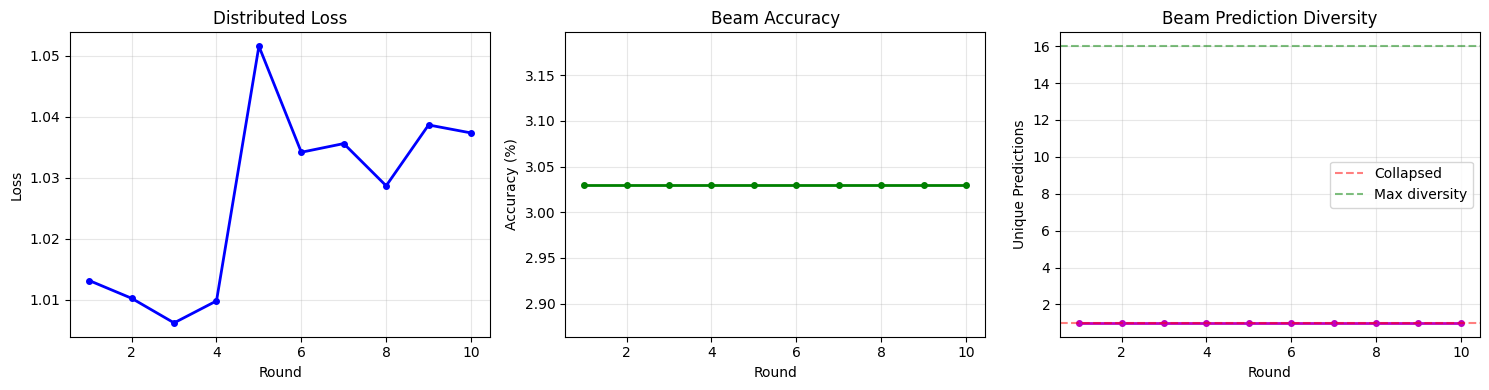

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss curve
if history.losses_distributed:
    rounds, losses = zip(*history.losses_distributed)
    axes[0].plot(rounds, losses, "b-o", linewidth=2, markersize=4)
axes[0].set_xlabel("Round"); axes[0].set_ylabel("Loss")
axes[0].set_title("Distributed Loss"); axes[0].grid(True, alpha=0.3)

# Beam accuracy
eval_m = history.metrics_distributed
if eval_m and "beam_accuracy" in eval_m:
    rds, accs = zip(*eval_m["beam_accuracy"])
    axes[1].plot(rds, [a * 100 for a in accs], "g-o", linewidth=2, markersize=4)
axes[1].set_xlabel("Round"); axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Beam Accuracy"); axes[1].grid(True, alpha=0.3)

# Prediction diversity
if eval_m and "beam_num_unique_preds" in eval_m:
    rds, div = zip(*eval_m["beam_num_unique_preds"])
    axes[2].plot(rds, div, "m-o", linewidth=2, markersize=4)
    axes[2].axhline(1, color="r", linestyle="--", alpha=0.5, label="Collapsed")
    axes[2].axhline(16, color="g", linestyle="--", alpha=0.5, label="Max diversity")
    axes[2].legend()
axes[2].set_xlabel("Round"); axes[2].set_ylabel("Unique Predictions")
axes[2].set_title("Beam Prediction Diversity"); axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
